In [1]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

# this makes sure cached files are readily available (for calling e.g. `gather_data_cached`)
!apt-get install git-lfs
!git lfs install

# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls

/content
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Git LFS initialized.
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 875, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 875 (delta 145), reused 125 (delta 49), pack-reused 620 (from 1)
Receiving objects: 100% (875/875), 27.23 MiB | 15.46 MiB/s, done.
Resolving deltas: 100% (499/499), done.
Filtering content: 100% (32/32), 1.75 GiB | 65.65 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [5]:
!pip install numpy==1.26.3 # necessary for bug fix

In [2]:
!pip install numpy==1.26.3 # necessary for bug fix
!pip install peft==0.10.0
!pip install ta
!pip install pykalman
!pip install PyWavelets
!pip install curl-cffi

## specific packages for time moe
# need a different version of accelerate because of bug "ImportError: cannot import name 'clear_device_cache' from 'accelerate.utils.memory'"
!pip install -U accelerate==0.32.0 # standard google colab version is 1.6.0 (apr 1, 2025), but for stability, we use time moe's 0.28.0 (mar 12, 2024)
!pip install transformers==4.40.1 # standard google colab version is 4.51.3, but time moe repo requirements mention/prefer 4.40.1 for stability
!pip install datasets==2.18.0
FLASH_ATTN = False # set to true if using this
if FLASH_ATTN:
  !pip install flash-attn==2.6.3 # optional but recommended by the repo

In [4]:
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm # note: using tqdm.auto usually automatically chooses the right import based on whether you're in CLI, notebook or somewhere else
import torch.nn as nn
import itertools
from pykalman import KalmanFilter
import ast
import re
from tabulate import tabulate
from datetime import datetime

# Custom Imports
from models.statistical_models import create_dataset, default_normalize, rmse_metric, acc_metric, kalman_filter_average, kalman_filter_regression, kalman_filter_regression_multivariate
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from preprocessing.wavelet_denoising import wav_den
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade, get_gt_yoy_returns_test_dev
from backtesting.utils import calculate_return_uncertainty
from utils.visualization import plot_return_uncertainty, plot_comparison
from utils.helpers import _get_train_dev_frac

# important for time moe
import wandb
wandb.login()

## workflow imports
from models.statistical_models import execute_kalman_workflow
from models.transformer_model import execute_transformer_workflow
from models.time_moe_model import execute_timemoe_workflow

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, _get_filename, gather_pairs_data_cached, gather_data_cached_using_truncate

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

inspect_func = True
if inspect_func:
  import inspect
  print(inspect.getsource(trade)) # in this case, check whether the new trade function  is imported

def trade(
        S1: pd.Series,
        S2: pd.Series,
        spread: pd.Series, # model-predicted spread for the strategy
        window_long: int,
        window_short: int,
        position_threshold: float = 1.0,
        clearing_threshold: float = 0.5,
        risk_fraction: float = 0.1 # could be used again
    ):   
    if len(spread) != len(S1) or len(spread) != len(S2):
        raise ValueError("Length of S1, S2, and spread must be the same")
    # Compute rolling mean and rolling standard deviation

    ma_long = spread.rolling(window=window_long, center=False).mean()
    ma_short = spread.rolling(window=window_short, center=False).mean()
    std = spread.rolling(window=window_short, center=False).std()
    zscore = (ma_long - ma_short)/std

    # Calculate initial cash based on average range of S1, S2 and Spread_Close, as these also determine the size of the trades
    s2_spread = max(S2) - min(S2)
    s1_spread = max(S1) - min(S1)
    spread_spread = max(spread) - min(sp

# All timeperiods:
```
# startDateStr = '2010-10-01'
# endDateStr = '2024-10-02'
# startDateStr = '2008-10-01'
# endDateStr = '2018-10-02'
# startDateStr = '2007-01-01'
# endDateStr = '2021-12-31'
# startDateStr = '2007-01-01'
# endDateStr = '2024-12-31'
# startDateStr = '2007-01-01'
# endDateStr = '2016-12-31'
# startDateStr = '2007-01-01'
# endDateStr = '2021-12-31'
```

## 1. Data gathering and filtering

In [5]:
# Step 1: Gather cached data and filter pairs based on cointegration and such
# NOTE: all the functions used here are explained in much more detail in src/main.ipynb, but this notebook is simply focused on finding how to ge the Transformer model to work as I wish.
# Set periods
startDateStr = '2008-01-01'
end_year = 2024
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01' # possibly change to 07-01 (option 1; dev data in end_year - 1 (e.g. 2023), test data in end_year (e.g. 2024) // option 2; dev data 1st half end_year, test data 2nd half end_year)
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.

# Extracting the variable `pairs_timeseries_df` can be done with code below
# ticker_a, ticker_b = pairs_data_filtered[0][0][0], pairs_data_filtered[0][0][1]
# pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)

# Note about pairs_timeseries_df: the timeseries target column is the spread of the closing prices, which is accessed using "Spread_Close"
# But, also the input features are the following keys: ['S1_rsi', 'S2_rsi', 'S1_mfi', 'S2_mfi', 'S1_adi', 'S2_adi', 'S1_vpt', 'S2_vpt', 'S1_atr', 'S2_atr', 'S1_bb_ma', 'S2_bb_ma', 'S1_adx', 'S2_adx', 'S1_ema', 'S2_ema', 'S1_macd', 'S2_macd', 'S1_dlr', 'S2_dlr']

## 2. Find best pair using Kalman Filters validation dataset (old)

Gathering test MSE (and returns) for different pairs..:   0%|          | 0/95 [00:00<?, ?it/s]

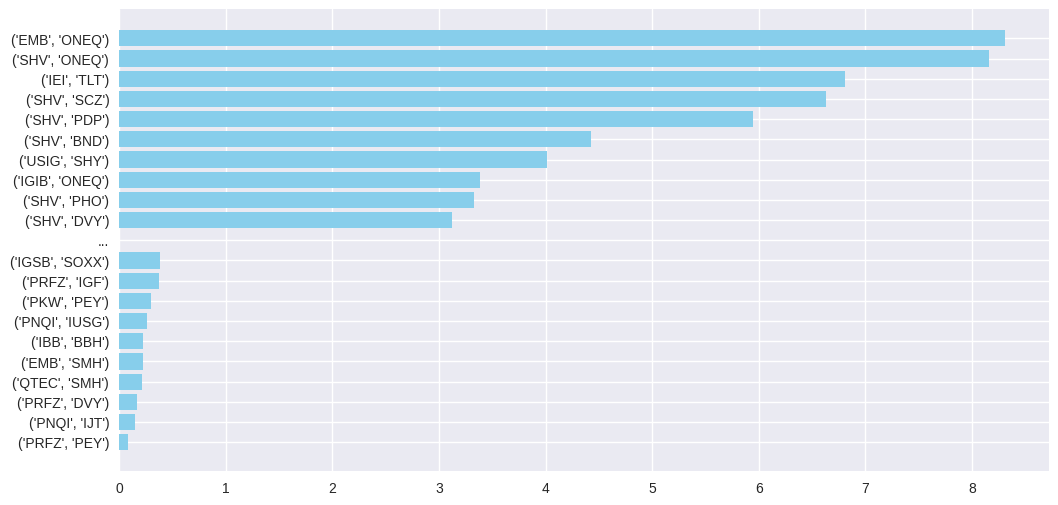

In [ ]:
# Step 2: From best cointegrated pairs, find highest validation MSE in Kalman Filters -> best pair
# Useful idea for the dev/validation data: go through all pairs, pick the pair with the highest validation MSE, and use that pair for getting a test MSE.
results = []
for i in tqdm(range(len(pairs_data_filtered)), desc = "Gathering test MSE (and returns) for different pairs.."):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=False, pair_tup_str=f"({ticker_a},{ticker_b})")
    results.append((str(pairs_data_filtered[i][0]), output['val_mse']))

best_scoring_pair_idx = results.index(min(results, key=lambda x: x[1])) # index of the best tuple
results.sort(key=lambda x: x[1])  # sort by MSE
x = 10
top_x = results[:x]
bottom_x = results[-x:]
combined = top_x + [('...', None)] + bottom_x
labels = [item[0] for item in combined]
values = [item[1] for item in combined]
plt.figure(figsize=(12, 6))
bars = plt.barh(labels, [v if v is not None else 0 for v in values], color='skyblue')

In [ ]:
# Pick the lowest MSE tickers from that and get the new data
ticker_a, ticker_b = pairs_data_filtered[best_scoring_pair_idx][0][0], pairs_data_filtered[best_scoring_pair_idx][0][1]
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)

## 3. Kalman Filter Results Test Dataset


In [ ]:
# Step 3: Use best pair for Kalman Filters
output_kalman = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=True, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", add_technical_indicators=False)

kalman_val_mse = output_kalman['val_mse']
kalman_test_mse = output_kalman['test_mse']
kalman_yoy_returns_str = f"{output_kalman['yoy_mean'] * 100:.2f}% +- {output_kalman['yoy_std'] * 100:.2f}%"

output_kalman_without_ta = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=True, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", add_technical_indicators=True)
kalman_val_mse_without_ta = output_kalman_without_ta['val_mse']
kalman_test_mse_without_ta = output_kalman_without_ta['test_mse']
kalman_yoy_returns_str_without_ta = f"{output_kalman_without_ta['yoy_mean'] * 100:.2f}% +- {output_kalman_without_ta['yoy_std'] * 100:.2f}%"

Split sizes — train: 2239, dev: 124, test: 125
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_kalman/data_2008_10_01_2018_10_02_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_kalman/data_2008_10_01_2018_10_02_4416cb3b_groundtruth_comparison.png

Validation MSE: 1.8406249646631174
Test MSE: 1.998517429613437
YOY Returns: 1.32%
YOY Std: +- 0.44%
GT Yoy: 42.99%
Plot filepath parent dir: data/results
Plot filenames: {'yoy_returns': 'data_2008_10_01_2018_10_02_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_10_01_2018_10_02_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 2239, dev: 124, test: 125
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_kalman/data_2008_10_01_2018_10_02_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_kalman/data_2008_10_01_2018_10_02_4416cb3b_groundtruth_comparison.png

Validation MSE: 0.

New method for gathering Kalman Filter Results

In [8]:
verbose = False

def return_score(yoy_mean, gt_yoy):
  if gt_yoy == -1:
    return -1
  return round((1 + yoy_mean) / (1 + gt_yoy), 2)

results = []
num_results = min(len(pairs_data_filtered), 30)
for i in tqdm(range(num_results), desc = "Gathering [...]"):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pair_tup_str_current = f"({ticker_a},{ticker_b})"
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
    gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
    output_model = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, add_technical_indicators=False)
    yoy_str = f"{output_model['yoy_mean'] * 100:.2f}% +- {output_model['yoy_std'] * 100:.2f}%"
    returns_score = return_score(output_model['yoy_mean'], gt_yoy)
    cointegration_score = pairs_data_filtered[i][1]
    results.append((pair_tup_str_current, cointegration_score, output_model['val_mse'], output_model['test_mse'], yoy_str, gt_yoy, returns_score)) # (pair, cointegration_score, val, test, yoy_str, gt_yoy, returns_score)


Gathering [...]:   0%|          | 0/30 [00:00<?, ?it/s]

In [16]:
def results_to_ascii_table(results):
    # Define column headers
    headers = [
        "Pair",
        "Cointegration Score",
        "val MSE",
        "test MSE",
        "YoY Returns (std)",
        "Theoretical Return Under Perfect Information",
        "Return Score"
    ]
    # Calculate the max width for each column
    cols = list(zip(*results))
    col_widths = [
        max(len(str(h)), *(len(str(cell)) for cell in col))
        for h, col in zip(headers, cols)
    ]
    # Helper to create a line separator
    def make_sep(char="+", pad="-"):
        return char + char.join(pad * (w + 2) for w in col_widths) + char

    def format_row(row, col_widths, row_idx=None, number_pair=False):
        formatted_cells = []
        for col_idx, (cell, w) in enumerate(zip(row, col_widths)):
            # Add numbering if required and it's the first column (Pair)
            if number_pair and col_idx == 0 and row_idx is not None:
                cell = f"{row_idx + 1}. {cell}"
            if col_idx == 1 and isinstance(cell, float):
                # format cointegration score in the format "x.x*10^x"
                cell = f"{cell:.2e}".replace("e","*10^")
            if col_idx == 5 and isinstance(cell, float):
                cell = f"{cell*100:.2f}%"
            if isinstance(cell, float):
                cell = f"{cell:.5f}"
            formatted_cells.append(f"{str(cell):<{w}}")
        return "| " + " | ".join(formatted_cells) + " |"

    # Build table
    lines = []
    lines.append(make_sep())
    lines.append(format_row(headers, col_widths))
    lines.append(make_sep(char="+", pad="="))
    for idx, row in enumerate(results):
        lines.append(format_row(row, col_widths, row_idx=idx, number_pair=True))
        lines.append(make_sep())
    return "\n".join(lines)
def results_to_latex(results):
    headers = [
        "Pair",
        "Cointegration Score",
        "val MSE",
        "test MSE",
        "YoY Returns (std)",
        "\makecell{Theoretical Return\\\\Under Perfect\\\\Information}",
        "Return Score"
    ]
    # Latex column alignment: l for first col, c for others
    align_str = "l" + "c" * (len(headers)-1)
    # Begin building latex table string
    lines = []
    lines.append("\\begin{table}[h]")
    lines.append("\\centering")
    lines.append("\\small")
    lines.append("\\resizebox{\\textwidth}{!}{")
    lines.append("\\begin{tabular}{" + align_str + "}")
    lines.append("\\toprule")
    lines.append(" & ".join(headers) + " \\\\")
    lines.append("\\midrule")
    for idx, row in enumerate(results):
        row_out = []
        for col_idx, cell in enumerate(row):
            # Add numbering for pairs
            if col_idx == 0:
                cell = f"{idx+1}. {cell}"
            # Format cointegration score as scientific in latex
            elif col_idx == 1 and isinstance(cell, float):
                base, exp = f"{cell:.2e}".split("e")
                exp = int(exp)
                cell = f"${base}\\times 10^{{{exp}}}$"
            # Theoretical return: show as percent if small, otherwise keep as float
            elif col_idx == 5 and isinstance(cell, float):
                cell = f"{cell*100:.2f}\\%"
            # Format YoY Returns (std) as $a\% \pm b\%$
            elif col_idx == 4 and isinstance(cell, str) and "%" in cell:
                # Convert e.g. '-82.63% +- 30.20%' to latex: $-82.63\% \pm 30.20\%$
                cell = cell.replace("%", "\\%")
                cell = cell.replace("+-", "\\pm")
                cell = f"${cell}$"
            elif col_idx == 6 and isinstance(cell, float):
              cell = f"{cell:.2f}"
            # General float formatting
            elif isinstance(cell, float):
                cell = f"{cell:.5f}"
            # Replace % in any string field (needed for e.g. theoretical return if not float)
            elif isinstance(cell, str) and "%" in cell:
                cell = cell.replace("%", "\\%")
            row_out.append(cell)
        # Join and add row
        lines.append(" & ".join(str(x) for x in row_out) + " \\\\")
    lines.append("\\bottomrule")
    lines.append("\\end{tabular}")
    lines.append("}")
    lines.append("\\caption{Model performance and return statistics for all tested pairs.}")
    lines.append("\\end{table}")
    return "\n".join(lines)



print(results_to_ascii_table(results))
print(results_to_latex(results))

+-------------+-----------------------+--------------------+--------------------+-------------------+----------------------------------------------+--------------+
| Pair        | Cointegration Score   | val MSE            | test MSE           | YoY Returns (std) | Theoretical Return Under Perfect Information | Return Score |
+=============+=======================+====================+====================+===================+==============================================+==============+
| 1. (PFF,EMB) | 1.38*10^-04           | 4.99826            | 13.49622           | -82.63% +- 30.20% | 3.31%                                        | 0.17000      |
+-------------+-----------------------+--------------------+--------------------+-------------------+----------------------------------------------+--------------+
| 2. (IFGL,MBB) | 4.45*10^-04           | 11.91925           | 9.53453            | 4.84% +- 0.34%    | -100.00%                                     | -1           |
+------------

## 4. Transformer Results Test Dataset


In [ ]:
# Step 4: Use best pair for Transformers

output_transformer = execute_transformer_workflow(pairs_timeseries_df, verbose=True, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", epochs=20)
transformer_val_mse = output_transformer['val_mse']
transformer_test_mse = output_transformer['test_mse']
transformer_yoy_returns_str = f"{output_transformer['yoy_mean'] * 100:.2f}% +- {output_transformer['yoy_std'] * 100:.2f}%"

output_transformer_without_ta = execute_transformer_workflow(pairs_timeseries_df, verbose=True, add_technical_indicators=False, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", epochs=20)
transformer_val_mse_without_ta = output_transformer_without_ta['val_mse']
transformer_test_mse_without_ta = output_transformer_without_ta['test_mse']
transformer_yoy_returns_str_without_ta = f"{output_transformer_without_ta['yoy_mean'] * 100:.2f}% +- {output_transformer_without_ta['yoy_std'] * 100:.2f}%"

Split sizes — train: 2239, dev: 124, test: 125
Single tensor shape: torch.Size([64, 20, 34])
Epoch 010 | train MSE 0.002908 | val MSE 0.053656
Epoch 020 | train MSE 0.003371 | val MSE 0.046558
Test MSE  : 0.231429
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_transformer/data_2008_10_01_2018_10_02_4416cb3b_train_val_loss.png
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_transformer/data_2008_10_01_2018_10_02_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_transformer/data_2008_10_01_2018_10_02_4416cb3b_groundtruth_comparison.png

Validation MSE: 0.0465578637444056
Test MSE: 0.23142890632152557
YOY Returns: 21.81%
YOY Std: +- 0.00%
GT Yoy: 30.71%
Plot filepath parent dir: data/results
Plot filenames: {'yoy_returns': 'data_2008_10_01_2018_10_02_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_10_01_2018_10_02_4416cb3b_groundtruth_comparison.png', 'train_val_loss': 'data_2008_10_01_2018_10

New method for Transformer results

In [26]:
verbose = True

results_transformer = []
num_results = min(len(pairs_data_filtered), 10) # do last 20 at a later point in time
for i in tqdm(range(num_results), desc = "Gathering [...]"):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pair_tup_str_current = f"({ticker_a},{ticker_b})"
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
    gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']

    # model-specific call
    output_model = execute_transformer_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), epochs=400)

    yoy_str = f"{output_model['yoy_mean'] * 100:.2f}% +- {output_model['yoy_std'] * 100:.2f}%"
    returns_score = return_score(output_model['yoy_mean'], gt_yoy)
    cointegration_score = pairs_data_filtered[i][1]
    results_transformer.append((pair_tup_str_current, cointegration_score, output_model['val_mse'], output_model['test_mse'], yoy_str, gt_yoy, returns_score))  # (pair, val, test, yoy_str, gt_yoy, returns_score)

Gathering [...]:   0%|          | 0/10 [00:00<?, ?it/s]

Split sizes — train: 3747, dev: 249, test: 251
Epoch 010 | train MSE 0.006025 | val MSE 0.000933
Epoch 020 | train MSE 0.005927 | val MSE 0.000640
Epoch 030 | train MSE 0.004366 | val MSE 0.000316
Epoch 040 | train MSE 0.004145 | val MSE 0.000948
Epoch 050 | train MSE 0.003279 | val MSE 0.000429
Epoch 060 | train MSE 0.002926 | val MSE 0.000328
Epoch 070 | train MSE 0.002854 | val MSE 0.000132
Epoch 080 | train MSE 0.002218 | val MSE 0.000132
Epoch 090 | train MSE 0.002452 | val MSE 0.000424
Epoch 100 | train MSE 0.001769 | val MSE 0.000498
Epoch 110 | train MSE 0.002102 | val MSE 0.000163
Epoch 120 | train MSE 0.001076 | val MSE 0.000119
Epoch 130 | train MSE 0.001291 | val MSE 0.000211
Epoch 140 | train MSE 0.000887 | val MSE 0.000174
Epoch 150 | train MSE 0.000808 | val MSE 0.000112
Epoch 160 | train MSE 0.000762 | val MSE 0.000113
Epoch 170 | train MSE 0.000629 | val MSE 0.000266
Epoch 180 | train MSE 0.000678 | val MSE 0.000125
Epoch 190 | train MSE 0.000680 | val MSE 0.000128
Epo

In [27]:
print(results_to_latex(results_transformer))

\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
1. (PFF,EMB) & $1.38\times 10^{-4}$ & 0.11437418 & 0.1663966 & $2.12\% \pm 0.17\%$ & 3.31\% & 0.99 \\
2. (IFGL,MBB) & $4.45\times 10^{-4}$ & 2.1898184 & 1.5658019 & $-91.82\% \pm 51.09\%$ & -100.00\% & -1 \\
3. (IFGL,EMB) & $7.27\times 10^{-4}$ & 0.098761424 & 0.17840905 & $6.49\% \pm 0.70\%$ & 11.61\% & 0.95 \\
4. (IGIB,IEI) & $7.97\times 10^{-4}$ & 0.4119866 & 0.21332882 & $1.26\% \pm 0.08\%$ & 1.38\% & 1.00 \\
5. (IGF,DVY) & $8.40\times 10^{-4}$ & 0.19719256 & 0.31040514 & $-100.00\% \pm 0.00\%$ & -100.00\% & -1 \\
6. (USIG,IEI) & $1.09\times 10^{-3}$ & 0.65612984 & 1.9924093 & $-39.57\% \pm 4.59\%$ & -63.21\% & 1.64 \\
7. (IFGL,BND) & $1.20\times 10^{-3}$ & 0.5551524 & 0.6196665 & $-49.14\% \pm 66.64\%$ & -100.00\% & -1 \\
8. (IFGL,SMH

## 5. Time-Moe Results Test Dataset


In [ ]:
# Step 5: Use best pair for Time-MoE.
output_time_moe = execute_timemoe_workflow(pairs_timeseries_df, verbose=True, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", load_finetuned=True)

time_moe_val_mse = output_time_moe['val_mse']
time_moe_test_mse = output_time_moe['test_mse']
time_moe_yoy_returns_str = f"{output_time_moe['yoy_mean'] * 100:.2f}% +- {output_time_moe['yoy_std'] * 100:.2f}%"

Split sizes — train: 2239, dev: 124, test: 125
devX_raw Shape: torch.Size([104, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 13 batches


/content/bsc-thesis/src/models/time_moe_model.py:84: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X = torch.tensor(X, dtype=torch.float32)


2025-05-20 11:02:25,033 - log_util.py[pid:2486;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/891 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/227M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

100%|██████████| 1/1 [00:00<00:00, 14926.35it/s]


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: davidmoerdijk (davidmoerdijk-smart-backoffice) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
1,0.029900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


configuration_time_moe.py:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Maple728/TimeMoE-50M:
- configuration_time_moe.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_timemoe/data_2008_10_01_2018_10_02_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_timemoe/data_2008_10_01_2018_10_02_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.014303365722298622
  Test MSE: 0.043884843587875366
  YOY Returns: 0.62%
  YOY Std: +- 0.02%
  GT Yoy: -0.36%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_10_01_2018_10_02_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_10_01_2018_10_02_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  


New method for Time-MoE results

In [20]:
verbose = True

results_timemoe = []
num_results = min(len(pairs_data_filtered), 30)
for i in tqdm(range(num_results), desc = "Gathering [...]"):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pair_tup_str_current = f"({ticker_a},{ticker_b})"
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
    gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']

    # model-specific call
    output_model = execute_timemoe_workflow(pairs_timeseries_df, verbose=verbose, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", load_finetuned=True, train_frac=train_frac, dev_frac=dev_frac)

    yoy_str = f"{output_model['yoy_mean'] * 100:.2f}% +- {output_model['yoy_std'] * 100:.2f}%"
    returns_score = return_score(output_model['yoy_mean'], gt_yoy)
    cointegration_score = pairs_data_filtered[i][1]
    results_timemoe.append((pair_tup_str_current, cointegration_score, output_model['val_mse'], output_model['test_mse'], yoy_str, gt_yoy, returns_score)) # (pair, val, test, yoy_str, gt_yoy, returns_score)

print(results_to_ascii_table(results_timemoe))

Gathering [...]:   0%|          | 0/30 [00:00<?, ?it/s]

Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:47:39,211 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4788.02it/s]


Step,Training Loss
1,0.033900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.10626720474380914
  Test MSE: 0.4826537213875417
  YOY Returns: -34.10%
  YOY Std: +- 48.50%
  GT Yoy: 3.81%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:47:53,106 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3858.61it/s]


Step,Training Loss
1,0.022500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.19378022252229113
  Test MSE: 3.4883055001561685
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:48:05,816 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1624.44it/s]


Step,Training Loss
1,0.023300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.09752060964894507
  Test MSE: 1.6178726656429931
  YOY Returns: -90.39%
  YOY Std: +- 56.62%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:48:18,513 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2933.08it/s]


Step,Training Loss
1,0.033000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.07641388307318146
  Test MSE: 0.2563485532396248
  YOY Returns: 1.05%
  YOY Std: +- 0.20%
  GT Yoy: 3.04%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:48:30,990 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3823.43it/s]


Step,Training Loss
1,0.012700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.05063662428789906
  Test MSE: 23.593868677905395
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:48:43,441 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3542.49it/s]


Step,Training Loss
1,0.039200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.09513408654055508
  Test MSE: 1.1785810379610075
  YOY Returns: -27.96%
  YOY Std: +- 7.58%
  GT Yoy: -82.79%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:48:55,945 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1807.89it/s]


Step,Training Loss
1,0.021600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.15533892236310864
  Test MSE: 4.376712280341166
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:49:08,283 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3137.10it/s]


Step,Training Loss
1,0.012000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.01981815813472943
  Test MSE: 40.98476914783131
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: 3284.18%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:49:20,351 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4707.41it/s]


Step,Training Loss
1,0.011700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.028791104082811384
  Test MSE: 66.52879076927792
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: 1430.14%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:49:32,687 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4266.84it/s]


Step,Training Loss
1,0.015900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.030073821404519877
  Test MSE: 11.02186251862157
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:49:45,164 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2465.79it/s]


Step,Training Loss
1,0.035300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.15599907083045644
  Test MSE: 0.4784039978936361
  YOY Returns: 14.07%
  YOY Std: +- 0.73%
  GT Yoy: 11.87%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:49:58,138 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4169.29it/s]


Step,Training Loss
1,0.011700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.019719014454439746
  Test MSE: 33.63708938419778
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:50:10,208 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4284.27it/s]


Step,Training Loss
1,0.011900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.037799794074691855
  Test MSE: 32.63836708729405
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: 624.11%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:50:22,508 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2568.47it/s]


Step,Training Loss
1,0.011600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.010359757531929827
  Test MSE: 19.05396989921377
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:50:34,955 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3518.71it/s]


Step,Training Loss
1,0.032200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.14266836780811976
  Test MSE: 0.8941654064487097
  YOY Returns: 4.73%
  YOY Std: +- 0.66%
  GT Yoy: 7.98%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:50:48,233 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4549.14it/s]


Step,Training Loss
1,0.034500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.0961773485945293
  Test MSE: 3.7554038402429617
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:51:01,124 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3530.56it/s]


Step,Training Loss
1,0.011500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.012105832382649217
  Test MSE: 14.881705701639449
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:51:14,035 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4644.85it/s]


Step,Training Loss
1,0.011500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.020037446875642954
  Test MSE: 53.98792843987852
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:51:26,746 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2914.74it/s]


Step,Training Loss
1,0.019500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.04686139633682592
  Test MSE: 7.103156709284399
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:51:39,491 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1875.81it/s]


Step,Training Loss
1,0.013500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.05285863206518613
  Test MSE: 6.598269501988467
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:51:52,366 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 5548.02it/s]


Step,Training Loss
1,0.011800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.026786195611873145
  Test MSE: 11.005609778542752
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: 1300.99%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:52:04,907 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4604.07it/s]


Step,Training Loss
1,0.011800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.032076519426814706
  Test MSE: 15.04881020166679
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:52:17,409 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4563.99it/s]


Step,Training Loss
1,0.011300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.026448952149693745
  Test MSE: 39.024302621859285
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:52:29,976 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4387.35it/s]


Step,Training Loss
1,0.022900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.10288118766561678
  Test MSE: 0.18549018165551587
  YOY Returns: -48.51%
  YOY Std: +- 14.42%
  GT Yoy: -51.19%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:52:43,519 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4593.98it/s]


Step,Training Loss
1,0.020700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.14618419537338048
  Test MSE: 5.924191110583507
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:52:55,957 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3360.82it/s]


Step,Training Loss
1,0.011600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.032993211897957765
  Test MSE: 15.465476006208851
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: 1153.60%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:53:08,328 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4573.94it/s]


Step,Training Loss
1,0.013500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.11199542494298871
  Test MSE: 2.2693217263565577
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:53:20,602 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3569.62it/s]


Step,Training Loss
1,0.022300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.07118460097165547
  Test MSE: 8.39840748365506
  YOY Returns: -96.24%
  YOY Std: +- 46.80%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:53:32,955 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3876.44it/s]


Step,Training Loss
1,0.012000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.06616518714585119
  Test MSE: 21.476504308036848
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: 230.21%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([229, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 29 batches
2025-05-27 13:53:45,191 - log_util.py[pid:64808;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2360.33it/s]


Step,Training Loss
1,0.031500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.03858134426831355
  Test MSE: 0.9283579037932566
  YOY Returns: 21.52%
  YOY Std: +- 4.46%
  GT Yoy: 38.44%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
+-------------+-----------------------+----------------------+---------------------+-------------------+----------------------------------------------+--------------+
| Pair        | Cointegration Score   | val MSE              | test MSE            | YoY Returns (std) | Theoretical Return Under Perfect Information | Return Score |
+=============+====

In [21]:
print(results_to_ascii_table(results_timemoe))
print(results_to_latex(results_timemoe))

+-------------+-----------------------+----------------------+---------------------+-------------------+----------------------------------------------+--------------+
| Pair        | Cointegration Score   | val MSE              | test MSE            | YoY Returns (std) | Theoretical Return Under Perfect Information | Return Score |
+=============+=======================+======================+=====================+===================+==============================================+==============+
| 1. (PFF,EMB) | 1.38*10^-04           | 0.10627              | 0.48265             | -34.10% +- 48.50% | 3.31%                                        | 0.64000      |
+-------------+-----------------------+----------------------+---------------------+-------------------+----------------------------------------------+--------------+
| 2. (IFGL,MBB) | 4.45*10^-04           | 0.19378              | 3.48831             | -100.00% +- 0.00% | -100.00%                                     | -1        

## 6. Gather results into table


In [ ]:
# Step 6: Get a table for the entire results of this time period using .txt files
start_year = re.search(r"\d{4}", startDateStr).group()
end_year = re.search(r"\d{4}", endDateStr).group()

latex_table = f"""
\\begin{{table}}[h]
\\centering
\\resizebox{{\\textwidth}}{{!}}{{%
\\begin{{tabular}}{{|l|ccc|ccc|}}
\\hline
\\textbf{{Model}} & \\multicolumn{{3}}{{c|}}{{\\textbf{{{start_year}--{end_year}}}}} \\\\
 & \\textbf{{val MSE}} & \\textbf{{test MSE}} & \\textbf{{YoY Returns (std)}} \\\\
\\hline
Kalman Filter & {kalman_val_mse:.4f} & {kalman_test_mse:.4f} & {kalman_yoy_returns_str} \\\\
Kalman Filter$^{{excl}}$ & {kalman_val_mse_without_ta:.4f} & {kalman_test_mse_without_ta:.4f} & {kalman_yoy_returns_str_without_ta} \\\\
Transformer & {transformer_val_mse or 'TBD'} & {transformer_test_mse or 'TBD'} & {transformer_yoy_returns_str or 'TBD'} \\\\
Transformer$^{{excl}}$ & {transformer_val_mse_without_ta or 'TBD'} & {transformer_test_mse_without_ta or 'TBD'} & {transformer_yoy_returns_str_without_ta or 'TBD'} \\\\
Time-MoE$^{{excl}}$ & {time_moe_val_mse or 'TBD'} & {time_moe_test_mse or 'TBD'} & {time_moe_yoy_returns_str or 'TBD'} \\\\
\\hline
\\end{{tabular}}%
}}
\\end{{table}}
"""
print(latex_table)

headers = ["Model", f"{start_year}–{end_year} val MSE", "test MSE", "YoY Returns (std)"]
rows = [
    ["Kalman Filter", f"{kalman_val_mse:.4f}", f"{kalman_test_mse:.4f}", kalman_yoy_returns_str],
    ["Kalman Filter^excl", f"{kalman_val_mse_without_ta:.4f}", f"{kalman_test_mse_without_ta:.4f}", kalman_yoy_returns_str_without_ta],
    ["Transformer", transformer_val_mse or "TBD", transformer_test_mse or "TBD", transformer_yoy_returns_str or "TBD"],
    ["Transformer^excl", transformer_val_mse_without_ta or "TBD", transformer_test_mse_without_ta or "TBD", transformer_yoy_returns_str_without_ta or "TBD"],
    ["Time-MoE^excl", time_moe_val_mse or "TBD", time_moe_test_mse or "TBD", time_moe_yoy_returns_str or "TBD"]
]

print(tabulate(rows, headers=headers, tablefmt="grid"))


\begin{table}[h]
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{|l|ccc|ccc|}
\hline
\textbf{Model} & \multicolumn{3}{c|}{\textbf{2008--2018}} \\
 & \textbf{val MSE} & \textbf{test MSE} & \textbf{YoY Returns (std)} \\
\hline
Kalman Filter & 1.8406 & 1.9985 & 1.32% +- 0.44% \\
Kalman Filter$^{excl}$ & 0.0804 & 0.0786 & 39.96% +- 2.72% \\
Transformer & 0.0465578637444056 & 0.23142890632152557 & 21.81% +- 0.00% \\
Transformer$^{excl}$ & 0.020511887394464932 & 0.1023695319890976 & 1.66% +- 0.53% \\
Time-MoE$^{excl}$ & TBD & TBD & TBD \\
\hline
\end{tabular}%
}
\end{table}

+--------------------+----------------------+---------------------+---------------------+
| Model              | 2008–2018 val MSE    | test MSE            | YoY Returns (std)   |
+====================+======================+=====================+=====================+
| Kalman Filter      | 1.8406               | 1.9985              | 1.32% +- 0.44%      |
+--------------------+----------------------+-----------

## 7. Repeat for 5 other time periods


In [ ]:
# Step 7: Make this into a function that gathers table at once, and repeat for all other time periods
def gather_results_timeperiod(startDateStr, endDateStr, train_frac, dev_frac, short_epochs = False):
  verbose = False

  instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
  data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
  data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
  data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

  pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
  if pairs_data_filtered is None:
    scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
    pairs_data = {key:value[1]  for (key, value) in pairs.items()}
    pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
    pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
  # Extract the most highly cointegrated pairs

  results = []
  results_profitable = []
  for i in tqdm(range(len(pairs_data_filtered)), desc = "Gathering test MSE (and returns) for different pairs.."):
      ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
      pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
      output = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
      gt_yoy, gt_yoy_for_dev_dataset = output['gt_yoy_test'], output['gt_yoy_dev']
      output = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=verbose, pair_tup_str=f"({ticker_a},{ticker_b})", train_frac=train_frac, dev_frac=dev_frac)
      results.append((str(pairs_data_filtered[i][0]), output['val_mse']))
      if gt_yoy > 0.2:
        results_profitable.append((str(pairs_data_filtered[i][0]), output['val_mse']))
  if results_profitable:
    results = results_profitable

  best_scoring_pair_idx = results.index(min(results, key=lambda x: x[1])) # index of the best tuple

  ticker_a, ticker_b = pairs_data_filtered[best_scoring_pair_idx][0][0], pairs_data_filtered[best_scoring_pair_idx][0][1]
  pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
  print(f"KALMAN: Best scoring pair idx: {best_scoring_pair_idx}, means we're using pair ({ticker_a}, {ticker_b})")

  # Step 3: Use best pair for Kalman Filters
  output_kalman = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=verbose, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", add_technical_indicators=False, train_frac=train_frac, dev_frac=dev_frac)

  kalman_val_mse = output_kalman['val_mse']
  kalman_test_mse = output_kalman['test_mse']
  kalman_yoy_returns_str = f"{output_kalman['yoy_mean'] * 100:.2f}% +- {output_kalman['yoy_std'] * 100:.2f}%"

  output_kalman_without_ta = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=verbose, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", add_technical_indicators=True, train_frac=train_frac, dev_frac=dev_frac)
  kalman_val_mse_without_ta = output_kalman_without_ta['val_mse']
  kalman_test_mse_without_ta = output_kalman_without_ta['test_mse']
  kalman_yoy_returns_str_without_ta = f"{output_kalman_without_ta['yoy_mean'] * 100:.2f}% +- {output_kalman_without_ta['yoy_std'] * 100:.2f}%"

  # Step 4.1: Find new best pair for Transformers using val MSE
  results = []
  results_profitable = []
  max_val_pairs = 50 # due to time constraints, only iterate over the top n cointegrated pairs (top n will automatically be done, as pairs_data_filtered is ordered based on cointegration scores by default)
  len(pairs_data_filtered)
  if len(pairs_data_filtered) < max_val_pairs:
    iterate_n_vals = len(pairs_data_filtered)
  else:
    iterate_n_vals = max_val_pairs

  for i in tqdm(range(iterate_n_vals), desc = "Gathering test MSE (and returns) for different pairs.."):
      ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
      pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
      output = execute_transformer_workflow(pairs_timeseries_df, verbose=False, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", train_frac=train_frac, dev_frac=dev_frac, epochs=10) # use very low amount of epochs for this stage
      results.append((str(pairs_data_filtered[i][0]), output['val_mse']))
      if gt_yoy > 0.2:
        results_profitable.append((str(pairs_data_filtered[i][0]), output['val_mse']))
  if results_profitable:
    results = results_profitable

  best_scoring_pair_idx = results.index(min(results, key=lambda x: x[1])) # index of the best tuple

  ticker_a, ticker_b = pairs_data_filtered[best_scoring_pair_idx][0][0], pairs_data_filtered[best_scoring_pair_idx][0][1]
  pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
  print(f"TRANSFORMER: Best scoring pair idx: {best_scoring_pair_idx}, means we're using pair ({ticker_a}, {ticker_b})")

  # Step 4: Use best pair for Transformers
  transformer_epochs = 400
  if short_epochs:
    transformer_epochs = 20

  output_transformer = execute_transformer_workflow(pairs_timeseries_df, verbose=verbose, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", epochs=transformer_epochs, train_frac=train_frac, dev_frac=dev_frac)
  transformer_val_mse = output_transformer['val_mse']
  transformer_test_mse = output_transformer['test_mse']
  transformer_yoy_returns_str = f"{output_transformer['yoy_mean'] * 100:.2f}% +- {output_transformer['yoy_std'] * 100:.2f}%"

  output_transformer_without_ta = execute_transformer_workflow(pairs_timeseries_df, verbose=verbose, add_technical_indicators=False, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", epochs=transformer_epochs, train_frac=train_frac, dev_frac=dev_frac)
  transformer_val_mse_without_ta = output_transformer_without_ta['val_mse']
  transformer_test_mse_without_ta = output_transformer_without_ta['test_mse']
  transformer_yoy_returns_str_without_ta = f"{output_transformer_without_ta['yoy_mean'] * 100:.2f}% +- {output_transformer_without_ta['yoy_std'] * 100:.2f}%"

  # Step 5.1: Find new best pair for Time-MoE
  results = []
  results_profitable = []
  max_val_pairs = 10 # due to time constraints, only iterate over the top n cointegrated pairs (top n will automatically be done, as pairs_data_filtered is ordered based on cointegration scores by default)
  len(pairs_data_filtered)
  if len(pairs_data_filtered) < max_val_pairs:
    iterate_n_vals = len(pairs_data_filtered)
  else:
    iterate_n_vals = max_val_pairs

  for i in tqdm(range(iterate_n_vals), desc = "Gathering test MSE (and returns) for different pairs.."):
      ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
      pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
      output = execute_timemoe_workflow(pairs_timeseries_df, verbose=verbose, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", load_finetuned=True, train_frac=train_frac, dev_frac=dev_frac)
      results.append((str(pairs_data_filtered[i][0]), output['val_mse']))
      if gt_yoy > 0.2:
        results_profitable.append((str(pairs_data_filtered[i][0]), output['val_mse']))
  if results_profitable:
    results = results_profitable

  best_scoring_pair_idx = results.index(min(results, key=lambda x: x[1])) # index of the best tuple

  ticker_a, ticker_b = pairs_data_filtered[best_scoring_pair_idx][0][0], pairs_data_filtered[best_scoring_pair_idx][0][1]
  pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
  print(f"TRANSFORMER: Best scoring pair idx: {best_scoring_pair_idx}, means we're using pair ({ticker_a}, {ticker_b})")


  # Step 5: Use best pair for Time-MoE.
  output_time_moe = execute_timemoe_workflow(pairs_timeseries_df, verbose=verbose, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", load_finetuned=True, train_frac=train_frac, dev_frac=dev_frac)

  time_moe_val_mse = output_time_moe['val_mse']
  time_moe_test_mse = output_time_moe['test_mse']
  time_moe_yoy_returns_str = f"{output_time_moe['yoy_mean'] * 100:.2f}% +- {output_time_moe['yoy_std'] * 100:.2f}%"

  # Step 6: Get a table for the entire results of this time period using .txt files
  start_year = re.search(r"\d{4}", startDateStr).group()
  end_year = re.search(r"\d{4}", endDateStr).group()

  # Some more formatting
  kalman_val_mse_formatted = f"{kalman_val_mse:.4f}" if kalman_val_mse is not None else 'TBD'
  kalman_test_mse_formatted = f"{kalman_test_mse:.4f}" if kalman_test_mse is not None else 'TBD'
  kalman_val_mse_without_ta_formatted = f"{kalman_val_mse_without_ta:.4f}" if kalman_val_mse_without_ta is not None else 'TBD'
  kalman_test_mse_without_ta_formatted = f"{kalman_test_mse_without_ta:.4f}" if kalman_test_mse_without_ta is not None else 'TBD'
  transformer_val_mse_formatted = f"{transformer_val_mse:.4f}" if transformer_val_mse is not None else 'TBD'
  transformer_test_mse_formatted = f"{transformer_test_mse:.4f}" if transformer_test_mse is not None else 'TBD'
  transformer_val_mse_without_ta_formatted = f"{transformer_val_mse_without_ta:.4f}" if transformer_val_mse_without_ta is not None else 'TBD'
  transformer_test_mse_without_ta_formatted = f"{transformer_test_mse_without_ta:.4f}" if transformer_test_mse_without_ta is not None else 'TBD'
  time_moe_val_mse_formatted = f"{time_moe_val_mse:.4f}" if time_moe_val_mse is not None else 'TBD'
  time_moe_test_mse_formatted = f"{time_moe_test_mse:.4f}" if time_moe_test_mse is not None else 'TBD'

  kalman_yoy_returns_str_escaped = kalman_yoy_returns_str.replace("%", "\\%")
  kalman_yoy_returns_str_without_ta_escaped = kalman_yoy_returns_str_without_ta.replace("%", "\\%")
  transformer_yoy_returns_str_escaped = transformer_yoy_returns_str.replace("%", "\\%")
  transformer_yoy_returns_str_without_ta_escaped = transformer_yoy_returns_str_without_ta.replace("%", "\\%")
  time_moe_yoy_returns_str_escaped = time_moe_yoy_returns_str.replace("%", "\\%")

  latex_table = f"""
  \\begin{{table}}[h]
  \\centering
  \\resizebox{{\\textwidth}}{{!}}{{%
  \\begin{{tabular}}{{|l|ccc|ccc|}}
  \\hline
  \\textbf{{Model}} & \\multicolumn{{3}}{{c|}}{{\\textbf{{{start_year}--{end_year}}}}} \\\\
  & \\textbf{{val MSE}} & \\textbf{{test MSE}} & \\textbf{{YoY Returns (std)}} \\\\
  \\hline
  Kalman Filter & {kalman_val_mse_formatted} & {kalman_test_mse_formatted} & {kalman_yoy_returns_str_escaped} \\\\
  Kalman Filter$^{{excl}}$ & {kalman_val_mse_without_ta_formatted} & {kalman_test_mse_without_ta_formatted} & {kalman_yoy_returns_str_without_ta_escaped} \\\\
  Transformer & {transformer_val_mse_formatted or 'TBD'} & {transformer_test_mse_formatted or 'TBD'} & {transformer_yoy_returns_str_escaped or 'TBD'} \\\\
  Transformer$^{{excl}}$ & {transformer_val_mse_without_ta_formatted or 'TBD'} & {transformer_test_mse_without_ta_formatted or 'TBD'} & {transformer_yoy_returns_str_without_ta_escaped or 'TBD'} \\\\
  Time-MoE$^{{excl}}$ & {time_moe_val_mse_formatted or 'TBD'} & {time_moe_test_mse_formatted or 'TBD'} & {time_moe_yoy_returns_str_escaped or 'TBD'} \\\\
  \\hline
  \\end{{tabular}}%
  }}
  \\end{{table}}
  """
  print(latex_table)

  headers = ["Model", f"{start_year}–{end_year} val MSE", "test MSE", "YoY Returns (std)"]
  rows = [
      ["Kalman Filter", f"{kalman_val_mse:.4f}", f"{kalman_test_mse:.4f}", kalman_yoy_returns_str],
      ["Kalman Filter^excl", f"{kalman_val_mse_without_ta:.4f}", f"{kalman_test_mse_without_ta:.4f}", kalman_yoy_returns_str_without_ta],
      ["Transformer", transformer_val_mse or "TBD", transformer_test_mse or "TBD", transformer_yoy_returns_str or "TBD"],
      ["Transformer^excl", transformer_val_mse_without_ta or "TBD", transformer_test_mse_without_ta or "TBD", transformer_yoy_returns_str_without_ta or "TBD"],
      ["Time-MoE^excl", time_moe_val_mse or "TBD", time_moe_test_mse or "TBD", time_moe_yoy_returns_str or "TBD"],
      ["Using Ground Truth Spread (According to Kalman)", "N/A", "N/A", output_kalman['gt_yoy'] or "TBD"],
      ["Using Ground Truth Spread (According to Kalman w/o TA)", "N/A", "N/A", output_kalman_without_ta['gt_yoy'] or "TBD"],
      ["Using Ground Truth Spread (According to Transformer)", "N/A", "N/A", output_transformer['gt_yoy'] or "TBD"],
      ["Using Ground Truth Spread (According to Transformer w/o TA)", "N/A", "N/A", output_transformer_without_ta['gt_yoy'] or "TBD"],
      ["Using Ground Truth Spread (According to Time MoE)", "N/A", "N/A", output_time_moe['gt_yoy'] or "TBD"]
  ]

  print(tabulate(rows, headers=headers, tablefmt="grid"))

  # save both tables to total_results
  total_results_dir = "data/results/total_results"
  os.makedirs(total_results_dir, exist_ok=True)

  with open(f"{total_results_dir}/table_{start_year}_{end_year}.tex", "w") as f:
      f.write(latex_table)

  with open(f"{total_results_dir}/table_{start_year}_{end_year}.txt", "w") as f:
      f.write(tabulate(rows, headers=headers, tablefmt="grid"))

# ## PERIOD 1
# startDateStr1 = '2010-10-01'
# endDateStr1 = '2024-10-02'
# train_frac1 = 0.90
# dev_frac1 = 0.05

# ## PERIOD 2
# startDateStr2 = '2008-10-01'
# endDateStr2 = '2018-10-02'
# train_frac2 = 0.90
# dev_frac2 = 0.05

# ## PERIOD 3
# startDateStr3 = '2007-01-01'
# endDateStr3 = '2022-12-31'
# # wanted test year: test 2022/01-2022/12
# startDateStrTest3 = '2022-01-01'
# endDateStrTest3 = '2022-12-31'
# train_frac3, dev_frac3 = _get_train_dev_frac(startDateStr3, endDateStr3, startDateStrTest3, endDateStrTest3)

# ## PERIOD 4
# startDateStr4 = '2007-01-01'
# endDateStr4 = '2024-12-31'
# # test 2024/01-2024/12
# startDateStrTest4 = '2024-01-01'
# endDateStrTest4 = '2024-12-31'
# train_frac4, dev_frac4 = _get_train_dev_frac(startDateStr4, endDateStr4, startDateStrTest4, endDateStrTest4)

# ## PERIOD 5
# startDateStr5 = '2007-01-01'
# endDateStr5 = '2016-12-31'
# # test 2014/07-2016
# startDateStrTest5 = '2014-07-01'
# endDateStrTest5 = '2016-12-31'
# train_frac5, dev_frac5 = _get_train_dev_frac(startDateStr5, endDateStr5, startDateStrTest5, endDateStrTest5)

# ## PERIOD 6
# startDateStr6 = '2007-01-01'
# endDateStr6 = '2021-12-31'
# # test 2020/01-2021/12
# startDateStrTest6 = '2020-01-01'
# endDateStrTest6 = '2021-12-31'
# train_frac6, dev_frac6 = _get_train_dev_frac(startDateStr6, endDateStr6, startDateStrTest6, endDateStrTest6)

# all_inputs = [
#     (startDateStr1, endDateStr1, train_frac1, dev_frac1),
#     (startDateStr2, endDateStr2, train_frac2, dev_frac2),
#     (startDateStr3, endDateStr3, train_frac3, dev_frac3),
#     (startDateStr4, endDateStr4, train_frac4, dev_frac4),
#     (startDateStr5, endDateStr5, train_frac5, dev_frac5),
#     (startDateStr6, endDateStr6, train_frac6, dev_frac6)
# ]

start_year = 2008
end_years = [2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016]
for end_year in end_years:
  startDateStrCurrent = f'{start_year}-01-01'
  endDateStrCurrent = f'{end_year}-12-31'
  startDateStrTestCurrent = f'{end_year}-01-01'
  endDateStrTestCurrent = f'{end_year}-12-31'
  train_frac_current, dev_frac_current = _get_train_dev_frac(startDateStrCurrent, endDateStrCurrent, startDateStrTestCurrent, endDateStrTestCurrent)

  gather_results_timeperiod(startDateStrCurrent, endDateStrCurrent, train_frac_current, dev_frac_current, short_epochs=False)

# for inputs in all_inputs:
#   gather_results_timeperiod(*inputs)

# For now, we are only gathering results for time period 2007-2021 (period 6)
# gather_results_timeperiod(startDateStr6, endDateStr6, train_frac6, dev_frac6, short_epochs=True)

Gathering test MSE (and returns) for different pairs..:   0%|          | 0/103 [00:00<?, ?it/s]

KALMAN: Best scoring pair idx: 3, means we're using pair (IGIB, IEI)


Gathering test MSE (and returns) for different pairs..:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 010 | train MSE 0.005402 | val MSE 0.000681
Epoch 010 | train MSE 0.003182 | val MSE 0.000241
Epoch 010 | train MSE 0.002328 | val MSE 0.000320
Epoch 010 | train MSE 0.006005 | val MSE 0.002091
Epoch 010 | train MSE 0.004099 | val MSE 0.007805
Epoch 010 | train MSE 0.006668 | val MSE 0.000828
Epoch 010 | train MSE 0.003615 | val MSE 0.000259
Epoch 010 | train MSE 0.003901 | val MSE 0.020970
Epoch 010 | train MSE 0.003834 | val MSE 0.012381
Epoch 010 | train MSE 0.003754 | val MSE 0.001300
Epoch 010 | train MSE 0.005554 | val MSE 0.000425
Epoch 010 | train MSE 0.003529 | val MSE 0.000919
Epoch 010 | train MSE 0.003687 | val MSE 0.001498
Epoch 010 | train MSE 0.003254 | val MSE 0.008557
Epoch 010 | train MSE 0.006163 | val MSE 0.000566
Epoch 010 | train MSE 0.005517 | val MSE 0.003096
Epoch 010 | train MSE 0.003270 | val MSE 0.006899
Epoch 010 | train MSE 0.003606 | val MSE 0.001521
Epoch 010 | train MSE 0.003095 | val MSE 0.001936
Epoch 010 | train MSE 0.003569 | val MSE 0.002856


Gathering test MSE (and returns) for different pairs..:   0%|          | 0/10 [00:00<?, ?it/s]

2025-05-24 18:17:33,337 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3415.56it/s]


Step,Training Loss
1,0.033900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 18:18:09,587 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3492.34it/s]


Step,Training Loss
1,0.022500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 18:18:38,822 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 898.91it/s]


Step,Training Loss
1,0.023300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 18:19:02,408 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3344.74it/s]


Step,Training Loss
1,0.033000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 18:19:26,412 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2326.29it/s]


Step,Training Loss
1,0.012700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 18:19:48,425 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2165.36it/s]


Step,Training Loss
1,0.039200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 18:20:11,366 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3331.46it/s]


Step,Training Loss
1,0.021600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 18:20:34,738 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2117.27it/s]


Step,Training Loss
1,0.012000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 18:20:56,708 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3919.91it/s]


Step,Training Loss
1,0.011700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 18:21:19,236 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2545.09it/s]


Step,Training Loss
1,0.015900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


TRANSFORMER: Best scoring pair idx: 7, means we're using pair (IFGL, SMH)
2025-05-24 18:21:42,167 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2761.23it/s]


Step,Training Loss
1,0.012000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



  \begin{table}[h]
  \centering
  \resizebox{\textwidth}{!}{%
  \begin{tabular}{|l|ccc|ccc|}
  \hline
  \textbf{Model} & \multicolumn{3}{c|}{\textbf{2008--2024}} \\
  & \textbf{val MSE} & \textbf{test MSE} & \textbf{YoY Returns (std)} \\
  \hline
  Kalman Filter & 1.0426 & 1.0280 & 0.15\% +- 0.04\% \\
  Kalman Filter$^{excl}$ & 1.9522 & 2.5681 & 10.70\% +- 2.40\% \\
  Transformer & 0.1818 & 2.4985 & 14.87\% +- 5.47\% \\
  Transformer$^{excl}$ & 0.0241 & 2.3826 & 37.99\% +- 5.25\% \\
  Time-MoE$^{excl}$ & 0.0198 & 40.9850 & 5839.90\% +- 478.81\% \\
  \hline
  \end{tabular}%
  }
  \end{table}
  
+-------------------------------------------------------------+----------------------+--------------------+-----------------------+
| Model                                                       | 2008–2024 val MSE    | test MSE           | YoY Returns (std)     |
+=============================================================+======================+====================+=======================+
| 

Gathering test MSE (and returns) for different pairs..:   0%|          | 0/102 [00:00<?, ?it/s]

KALMAN: Best scoring pair idx: 12, means we're using pair (PFF, BND)


Gathering test MSE (and returns) for different pairs..:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 010 | train MSE 0.004730 | val MSE 0.001370
Epoch 010 | train MSE 0.002387 | val MSE 0.002566
Epoch 010 | train MSE 0.003686 | val MSE 0.000502
Epoch 010 | train MSE 0.005799 | val MSE 0.009228
Epoch 010 | train MSE 0.006837 | val MSE 0.009718
Epoch 010 | train MSE 0.006542 | val MSE 0.008236
Epoch 010 | train MSE 0.002965 | val MSE 0.001379
Epoch 010 | train MSE 0.003717 | val MSE 0.001108
Epoch 010 | train MSE 0.003298 | val MSE 0.007012
Epoch 010 | train MSE 0.003744 | val MSE 0.000850
Epoch 010 | train MSE 0.004293 | val MSE 0.003458
Epoch 010 | train MSE 0.003696 | val MSE 0.000518
Epoch 010 | train MSE 0.005472 | val MSE 0.002496
Epoch 010 | train MSE 0.004907 | val MSE 0.001505
Epoch 010 | train MSE 0.003594 | val MSE 0.002029
Epoch 010 | train MSE 0.003450 | val MSE 0.000570
Epoch 010 | train MSE 0.002681 | val MSE 0.001752
Epoch 010 | train MSE 0.005631 | val MSE 0.000535
Epoch 010 | train MSE 0.003355 | val MSE 0.000658
Epoch 010 | train MSE 0.005837 | val MSE 0.006842


Gathering test MSE (and returns) for different pairs..:   0%|          | 0/10 [00:00<?, ?it/s]

2025-05-24 18:39:38,838 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3566.59it/s]


Step,Training Loss
1,0.034400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 18:40:03,062 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3837.42it/s]


Step,Training Loss
1,0.022400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 18:40:37,472 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2402.24it/s]


Step,Training Loss
1,0.013000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 18:41:16,230 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3398.95it/s]


Step,Training Loss
1,0.034200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 18:41:51,443 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3294.82it/s]


Step,Training Loss
1,0.023500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 18:42:20,197 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2868.88it/s]


Step,Training Loss
1,0.041200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 18:42:49,897 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2411.91it/s]


Step,Training Loss
1,0.021600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 18:43:20,806 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3606.45it/s]


Step,Training Loss
1,0.011500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 18:43:46,490 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2201.73it/s]


Step,Training Loss
1,0.022200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 18:44:20,450 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4021.38it/s]


Step,Training Loss
1,0.011500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


TRANSFORMER: Best scoring pair idx: 3, means we're using pair (IGIB, IEI)
2025-05-24 18:44:49,846 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2746.76it/s]


Step,Training Loss
1,0.034200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



  \begin{table}[h]
  \centering
  \resizebox{\textwidth}{!}{%
  \begin{tabular}{|l|ccc|ccc|}
  \hline
  \textbf{Model} & \multicolumn{3}{c|}{\textbf{2008--2023}} \\
  & \textbf{val MSE} & \textbf{test MSE} & \textbf{YoY Returns (std)} \\
  \hline
  Kalman Filter & 0.7836 & 1.4478 & 2.00\% +- 0.17\% \\
  Kalman Filter$^{excl}$ & 1.0237 & 5.8457 & 11.43\% +- 3.89\% \\
  Transformer & 0.1159 & 0.7740 & -1.25\% +- 0.14\% \\
  Transformer$^{excl}$ & 0.0556 & 0.5263 & -1.61\% +- 0.21\% \\
  Time-MoE$^{excl}$ & 0.0326 & 1.0150 & -0.93\% +- 0.16\% \\
  \hline
  \end{tabular}%
  }
  \end{table}
  
+-------------------------------------------------------------+----------------------+--------------------+-----------------------+
| Model                                                       | 2008–2023 val MSE    | test MSE           | YoY Returns (std)     |
+=============================================================+======================+====================+=======================+
| Kalma

Gathering test MSE (and returns) for different pairs..:   0%|          | 0/86 [00:00<?, ?it/s]

KALMAN: Best scoring pair idx: 7, means we're using pair (IFGL, SOXX)


Gathering test MSE (and returns) for different pairs..:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 010 | train MSE 0.004670 | val MSE 0.000928
Epoch 010 | train MSE 0.002630 | val MSE 0.000355
Epoch 010 | train MSE 0.005659 | val MSE 0.002558
Epoch 010 | train MSE 0.006958 | val MSE 0.015766
Epoch 010 | train MSE 0.003300 | val MSE 0.012967
Epoch 010 | train MSE 0.007138 | val MSE 0.013770
Epoch 010 | train MSE 0.006281 | val MSE 0.000428
Epoch 010 | train MSE 0.003917 | val MSE 0.005435
Epoch 010 | train MSE 0.003687 | val MSE 0.004909
Epoch 010 | train MSE 0.003945 | val MSE 0.010842
Epoch 010 | train MSE 0.003641 | val MSE 0.002262
Epoch 010 | train MSE 0.003422 | val MSE 0.002551
Epoch 010 | train MSE 0.003646 | val MSE 0.003447
Epoch 010 | train MSE 0.003475 | val MSE 0.004619
Epoch 010 | train MSE 0.005240 | val MSE 0.001275
Epoch 010 | train MSE 0.003371 | val MSE 0.001289
Epoch 010 | train MSE 0.004922 | val MSE 0.004932
Epoch 010 | train MSE 0.003528 | val MSE 0.029931
Epoch 010 | train MSE 0.003358 | val MSE 0.033447
Epoch 010 | train MSE 0.003407 | val MSE 0.000751


Gathering test MSE (and returns) for different pairs..:   0%|          | 0/10 [00:00<?, ?it/s]

2025-05-24 19:01:10,720 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3355.44it/s]


Step,Training Loss
1,0.033000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 19:01:34,685 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2522.13it/s]


Step,Training Loss
1,0.021600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 19:01:58,486 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 512.56it/s]


Step,Training Loss
1,0.027100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 19:02:38,828 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2537.39it/s]


Step,Training Loss
1,0.040500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 19:03:20,729 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1454.84it/s]


Step,Training Loss
1,0.013500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 19:03:59,106 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2577.94it/s]


Step,Training Loss
1,0.023100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 19:04:45,271 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3209.11it/s]


Step,Training Loss
1,0.034600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 19:05:17,807 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2781.37it/s]


Step,Training Loss
1,0.012300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 19:06:06,022 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2194.82it/s]


Step,Training Loss
1,0.012200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-05-24 19:06:51,733 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2424.45it/s]


Step,Training Loss
1,0.013400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


TRANSFORMER: Best scoring pair idx: 9, means we're using pair (IFGL, PHO)
2025-05-24 19:07:38,724 - log_util.py[pid:2080;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2449.94it/s]


Step,Training Loss
1,0.013400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



  \begin{table}[h]
  \centering
  \resizebox{\textwidth}{!}{%
  \begin{tabular}{|l|ccc|ccc|}
  \hline
  \textbf{Model} & \multicolumn{3}{c|}{\textbf{2008--2022}} \\
  & \textbf{val MSE} & \textbf{test MSE} & \textbf{YoY Returns (std)} \\
  \hline
  Kalman Filter & 2.3188 & 2.3886 & -1.30\% +- 3.31\% \\
  Kalman Filter$^{excl}$ & 0.4117 & 0.0852 & -22.34\% +- 39.20\% \\
  Transformer & 0.6235 & 0.5521 & -53.95\% +- 2.63\% \\
  Transformer$^{excl}$ & 1.2397 & 0.5931 & -28.90\% +- 4.49\% \\
  Time-MoE$^{excl}$ & 0.0217 & 18.9503 & 47.16\% +- 13.92\% \\
  \hline
  \end{tabular}%
  }
  \end{table}
  
+-------------------------------------------------------------+----------------------+--------------------+----------------------+
| Model                                                       | 2008–2022 val MSE    | test MSE           | YoY Returns (std)    |
+=============================================================+======================+====================+======================+
| K

Processing pairs: 100%|██████████| 630/630 [02:19<00:00,  4.51it/s]

Completed 630 pairs


Gathering test MSE (and returns) for different pairs..:   0%|          | 0/91 [00:00<?, ?it/s]

/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))
/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))
/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))


KALMAN: Best scoring pair idx: 6, means we're using pair (IFGL, PHO)


Gathering test MSE (and returns) for different pairs..:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 010 | train MSE 0.005522 | val MSE 0.001766
Epoch 010 | train MSE 0.002472 | val MSE 0.003942
Epoch 010 | train MSE 0.004135 | val MSE 0.003814
Epoch 010 | train MSE 0.006711 | val MSE 0.068090
Epoch 010 | train MSE 0.003733 | val MSE 0.027359
Epoch 010 | train MSE 0.003625 | val MSE 0.033867
Epoch 010 | train MSE 0.003407 | val MSE 0.015135
Epoch 010 | train MSE 0.003060 | val MSE 0.026392
Epoch 010 | train MSE 0.003379 | val MSE 0.009839
Epoch 010 | train MSE 0.003245 | val MSE 0.012473
Epoch 010 | train MSE 0.002870 | val MSE 0.035825
Epoch 010 | train MSE 0.003285 | val MSE 0.003203
Epoch 010 | train MSE 0.004498 | val MSE 0.001840
Epoch 010 | train MSE 0.002950 | val MSE 0.001194


In [ ]:
import random
def execute_kalman_workflow(
  pair_data: pd.DataFrame,
  col_s1: str = "S1_close",
  col_s2: str = "S2_close",
  burn_in: int = 30,
  train_frac: float = 0.90,
  dev_frac: float = 0.05,
  seed: int = 3178749, # for reproducibility, my student number
  look_back: int = 1,
  denoise_fn: Optional[Callable[[pd.Series], np.ndarray]] = wav_den,
  scaler_factory: Callable[..., MinMaxScaler] = MinMaxScaler,
  scaler_kwargs: Optional[Dict[str, Any]] = {"feature_range": (0, 1)},
  normalise_fn: Callable[[pd.Series], pd.Series] = default_normalize,
  delta: float = 1e-3,
  obs_cov_reg: float = 2.,
  trans_cov_avg: float = 0.01,
  obs_cov_avg: float = 1.,
  return_datasets: bool = False,
  verbose: bool = True,
  add_technical_indicators: bool = True,
  result_parent_dir: str = "data/results",
  filename_base: str = "data_begindate_enddate_hash.pkl", # use `_get_filename(startDateStr, endDateStr, instrumentIds)`
  pair_tup_str: str = "(?,?)" # Used for showing which tuple was used in plots, example: "(QQQ, SPY)"
):
  # Set seeds
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

  # For GPU (if used)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False  # Might slow down, but ensures determinism

  # Check whether everything is present as expected (good practice, and gives useful exceptions)
  required = {col_s1, col_s2}
  if not required.issubset(pair_data.columns):
      raise KeyError(f"pair_data must contain {required}")

  keep_cols = [c for c in pair_data.columns if c not in ("date",)]
  df = pair_data[keep_cols].iloc[burn_in:].copy()

  total_len = len(df)
  train_size = int(total_len * train_frac)
  dev_size   = int(total_len * dev_frac)
  test_size  = total_len - train_size - dev_size # not used, but for clarity

  train = df.iloc[:train_size]
  dev   = df.iloc[train_size:train_size + dev_size]
  test  = df.iloc[train_size + dev_size:]

  if verbose:
      print(f"Split sizes — train: {len(train)}, dev: {len(dev)}, test: {len(test)}")

  if denoise_fn is not None: # denoise using wavelet denoising
      train = pd.DataFrame({col: denoise_fn(train[col]) for col in keep_cols})

  if scaler_factory is not None:
      scaler = scaler_factory(**(scaler_kwargs or {}))
  else:
      scaler = None


  trainX_untr, trainX, trainY_untr, trainY = create_dataset(train.values, scaler=scaler, look_back=look_back)
  devX_untr,   devX,   devY_untr,   devY   = create_dataset(dev.values,  scaler=scaler, look_back=look_back)
  testX_untr,  testX,  testY_untr,  testY  = create_dataset(test.values, scaler=scaler, look_back=look_back)

  if add_technical_indicators:
      # Predict S1_close using all other columns except S1_close as X, making it multivariate regression with a very large number of variables (the technical indicators)
      y_train = train[col_s1].values
      X_train = train.drop(columns=[col_s1]).values # all input variables

      # do the same for dev and test
      y_dev = dev[col_s1].values
      X_dev = dev.drop(columns=[col_s1]).values
      y_test = test[col_s1].values
      X_test = test.drop(columns=[col_s1]).values

      # apply scaler to all versions of the input
      if scaler is not None:
          X_train = scaler.fit_transform(X_train)
          X_dev = scaler.transform(X_dev)
          X_test = scaler.transform(X_test)

      # recursive least squares multivariate regression, using the function
      beta_t = kalman_filter_regression_multivariate(X_train, y_train, delta=delta)
      forecast_train = np.sum(X_train * beta_t, axis=1)
      forecast_dev   = np.sum(X_dev * beta_t[-len(X_dev):], axis=1)
      forecast_test  = np.sum(X_test * beta_t[-len(X_test):], axis=1)

      if look_back == 1:
          forecast_test_list = [np.array([v]) for v in forecast_test] # this way of calculating MSE is a bit messy and too many steps, but it works in the workflow now, so we'll keep it like this.
          testY_arr = np.array(y_test).reshape(-1, 1)
          testY_list = [np.array([v]) for v in y_test]
          test_mse = acc_metric(testY_list, forecast_test_list)
          test_var = np.var(testY_arr)
          test_nmse = test_mse / test_var if test_var != 0 else 0.0

          # # repeat for dev / validaiton
          forecast_dev_list = [np.array([v]) for v in forecast_dev]
          devY_arr = np.array(y_dev).reshape(-1, 1)
          devY_list = [np.array([v]) for v in y_dev]
          val_mse = acc_metric(devY_list, forecast_dev_list)
          val_var = np.var(devY_arr)
          val_nmse = val_mse / val_var if val_var != 0 else 0.0
      else:
          print("Warning: look_back > 1 not yet implemented. Returning None for mse.")
          test_mse, val_mse = None, None
  else:
    # get beta_t, the Kalman-filtered regression coefficients
    beta_t = kalman_filter_regression(
        kalman_filter_average(pair_data[col_s1],
                              transition_cov=trans_cov_avg,
                              obs_cov=obs_cov_avg),
        kalman_filter_average(pair_data[col_s2],
                              transition_cov=trans_cov_avg,
                              obs_cov=obs_cov_avg),
        delta=delta,
        obs_cov=obs_cov_reg
    )[:, 0]

    kalman_spread = normalise_fn(
        pair_data[col_s1] + pair_data[col_s2] * beta_t)

    forecast_train = kalman_spread[:len(trainX)].to_numpy() # Though the variable `forecast_train` is never directly used as a variable, the data for it WAS used, during kalman filter averaging and regression
    forecast_dev   = kalman_spread[len(trainX):len(trainX) + len(devX)].to_numpy()
    forecast_test = kalman_spread[-len(testX):].to_numpy()

    if look_back == 1:
        yhat_KF_mse = [np.array([v]) for v in forecast_test]

        # Original normalisation: operate directly on the list-of-arrays
        testY_arr  = np.array(testY_untr)               # shape (N,1)
        testY_norm = (testY_arr - testY_arr.mean()) / testY_arr.std()

        # Convert back to list-of-arrays so acc_metric sees the same layout
        testY_norm_list = [row for row in testY_norm]

        test_mse = acc_metric(testY_norm_list, yhat_KF_mse)
        test_var = np.var(testY_norm)
        test_nmse = test_mse / test_var if test_var != 0 else 0.0

        yhat_KF_dev_mse = [np.array([v]) for v in forecast_dev]
        devY_arr = np.array(devY_untr)
        devY_norm = (devY_arr - devY_arr.mean()) / devY_arr.std()
        devY_norm_list = [row for row in devY_norm]
        val_mse = acc_metric(devY_norm_list, yhat_KF_dev_mse)
        val_var = np.var(devY_norm)
        val_nmse = val_mse / val_var if val_var != 0 else 0.0
    else:
        print("Warning: look_back > 1 not yet implemented. Returning None for mse.")
        test_mse = None
        val_mse = None

  ### TRADING ###
  # calculate std_dev_pct using the logic from plot_with_uncertainty. Then put that into two separate functions: calculate_yoy_uncertainty and a version of plot_with_uncertainty that uses calculate_yoy_uncertainty
  # position threshold (2.00-4.00), clearing threshold (0.30-0.70)
  min_position = 2.00
  max_position = 4.00
  min_clearing = 0.30
  max_clearing = 0.70
  position_thresholds = np.linspace(min_position, max_position, num=10)
  clearing_thresholds = np.linspace(min_clearing, max_clearing, num=10)

  test_index_shortened = test.index[:len(testY_untr)]
  forecast_test_shortened_series = pd.Series(forecast_test[:len(testY_untr)], index=test_index_shortened)
  testY_untr_shortened = pd.Series(testY_untr, index=test_index_shortened)
  test_s1_shortened = test['S1_close'].iloc[:len(testY_untr)]
  test_s2_shortened = test['S2_close'].iloc[:len(testY_untr)]

  yoy_mean, yoy_std = calculate_return_uncertainty(test_s1_shortened, test_s2_shortened, forecast_test_shortened_series, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds)
  # calculate the strategy returns if we were to feed the groundtruth values to the `trade` func. If the ground truth returns are lower, it seems likely there is something wrong with the `trade` func (but not certain! Probability applies here).
  # forecast_test_shortened = forecast_test[:len(testY_untr)]
  # spread_pred_series = pd.Series(forecast_test_shortened, index=index_shortened)
  index_shortened = test.index[:len(test['Spread_Close'].values[look_back:])]
  spread_gt_series = pd.Series(test['Spread_Close'].values[look_back:], index=index_shortened)
  gt_returns = trade(
      S1 = test['S1_close'].iloc[look_back:],
      S2 = test['S2_close'].iloc[look_back:],
      spread = spread_gt_series,
      window_long = 30,
      window_short = 5,
      position_threshold = 3,
      clearing_threshold = 0.4
  )
  gt_yoy = ((gt_returns[-1] / gt_returns[0])**(365 / len(gt_returns)) - 1)

  if add_technical_indicators:
    current_result_dir = filename_base.replace(".pkl", "_kalman")
  else:
    current_result_dir = filename_base.replace(".pkl", "_kalman_without_ta")
  result_dir = os.path.join(result_parent_dir, current_result_dir)
  if not os.path.exists(result_dir):
      os.makedirs(result_dir)
  yoy_returns_filename = plot_return_uncertainty(test_s1_shortened, test_s2_shortened, forecast_test_shortened_series, test_index_shortened, look_back, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds, verbose=verbose, result_dir=result_dir, filename_base=filename_base)
  predicted_vs_actual_spread_filename = plot_comparison(testY_untr, forecast_test, test.index, workflow_type="Kalman Filter", pair_tup_str=pair_tup_str, verbose=verbose, result_dir=result_dir, filename_base=filename_base)
  plot_filenames = {
      "yoy_returns": yoy_returns_filename,
      "predicted_vs_actual_spread": predicted_vs_actual_spread_filename,
      "train_val_loss": None
  }
  # save results to .txt file
  results_str = f"""
Validation MSE: {val_nmse}
Test MSE: {test_nmse}
YOY Returns: {yoy_mean * 100:.2f}%
YOY Std: +- {yoy_std * 100:.2f}%
GT Yoy: {gt_yoy * 100:.2f}%
Plot filepath parent dir: {result_parent_dir}
Plot filenames: {plot_filenames}
  """
  with open(os.path.join(result_dir, "results.txt"), "w") as f:
      f.write(results_str)


  if verbose:
    print(results_str)
  output: Dict[str, Any] = dict(
      val_mse=val_nmse,
      test_mse=test_nmse,
      yoy_mean=yoy_mean,
      yoy_std=yoy_std,
      gt_yoy=gt_yoy,
      result_parent_dir=result_parent_dir,
      plot_filenames=plot_filenames
  )
  if return_datasets:
      output.update(
          dict(train=train, dev=dev, test=test,
                datasets=dict(
                    train=(trainX_untr, trainX, trainY_untr, trainY),
                    dev  =(devX_untr,   devX,   devY_untr,   devY),
                    test =(testX_untr,  testX,  testY_untr,  testY)
                ))
      )
  return output


In [ ]:
# zip data/results
import shutil
shutil.make_archive('results', 'zip', 'data/results')

'/content/bsc-thesis/src/results.zip'

Let's go a little bit deeper into the GT trading results.

1. Reproducing Kalman Filter GT YoY results outside of its workflow function.

In [ ]:
verbose = False
startDateStr, endDateStr, train_frac, dev_frac = startDateStr6, endDateStr6, train_frac6, dev_frac6

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
pairs_data = {key:value[1]  for (key, value) in pairs.items()}
pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
# Extract the most highly cointegrated pairs

results = []
for i in tqdm(range(len(pairs_data_filtered)), desc = "Gathering test MSE (and returns) for different pairs.."):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=verbose, pair_tup_str=f"({ticker_a},{ticker_b})")
    results.append((str(pairs_data_filtered[i][0]), output['val_mse']))

best_scoring_pair_idx = results.index(min(results, key=lambda x: x[1])) # index of the best tuple

ticker_a, ticker_b = pairs_data_filtered[best_scoring_pair_idx][0][0], pairs_data_filtered[best_scoring_pair_idx][0][1]
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
print(f"Best scoring pair idx: {best_scoring_pair_idx}, means we're using pair ({ticker_a}, {ticker_b})")


# Kalman would then be called using
# output_kalman = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=verbose, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", add_technical_indicators=False)
# but we will do this manually in a code block below

Processing pairs: 100%|██████████| 253/253 [00:53<00:00,  4.76it/s]

Completed 253 pairs


Gathering test MSE (and returns) for different pairs..:   0%|          | 0/7 [00:00<?, ?it/s]

Best scoring pair idx: 6, means we're using pair (SOXX, SMH)


In [ ]:
pair_data = pairs_timeseries_df
burn_in = 30
look_back = 1
scaler_factory: Callable[..., MinMaxScaler] = MinMaxScaler
scaler_kwargs: Optional[Dict[str, Any]] = {"feature_range": (0, 1)}
extra_scaling_bool = True

keep_cols = [c for c in pair_data.columns if c not in ("date",)]

df = pair_data[keep_cols].iloc[burn_in:].copy()

total_len = len(df)
train_size = int(total_len * train_frac)
dev_size   = int(total_len * dev_frac)



train = df.iloc[:train_size]
dev   = df.iloc[train_size:train_size + dev_size]
test  = df.iloc[train_size + dev_size:]

scaler = scaler_factory(**(scaler_kwargs or {}))

testX_untr,  testX,  testY_untr,  testY  = create_dataset(test.values, scaler=scaler, look_back=look_back)
if extra_scaling_bool:
  devX_untr,   devX,   devY_untr,   devY   = create_dataset(dev.values,  scaler=scaler, look_back=look_back)
  testX_untr,  testX,  testY_untr,  testY  = create_dataset(test.values, scaler=scaler, look_back=look_back)


index_shortened = test.index[:len(testY_untr)]
spread_gt_series = pd.Series(testY_untr, index=index_shortened)
gt_returns = trade(
    S1 = test['S1_close'].iloc[look_back:],
    S2 = test['S2_close'].iloc[look_back:],
    spread = spread_gt_series,
    window_long = 30,
    window_short = 5,
    position_threshold = 3,
    clearing_threshold = 0.4
)
gt_yoy = ((gt_returns[-1] / gt_returns[0])**(365 / len(gt_returns)) - 1)[0]
print(f"a) pair_data shape: {pair_data.shape}")
print(f"a) pair_data: {pair_data.head()[:3]}")
print(f"b) spread_gt_series: {spread_gt_series[:10]} with length {len(spread_gt_series)}")
gt_yoy

a) pair_data shape: (3776, 34)
a) pair_data:              S1_close   S2_close    S1_open    S2_open    S1_high    S2_high  \
Date                                                                           
2007-01-03  20.276667  16.785000  20.563334  16.924999  20.740000  17.110001   
2007-01-04  20.673332  17.094999  20.276667  16.754999  20.736668  17.180000   
2007-01-05  20.280001  16.924999  20.320000  16.950001  20.483334  17.025000   

               S1_low     S2_low  S1_volume  S2_volume  ...  S1_ema  S2_ema  \
Date                                                    ...                   
2007-01-03  20.083332  16.565001     509400   26994000  ...     NaN     NaN   
2007-01-04  20.243334  16.750000     462300   28808200  ...     NaN     NaN   
2007-01-05  20.120001  16.809999     241500   33599800  ...     NaN     NaN   

            S1_macd  S2_macd    S1_dlr    S2_dlr  Spread_Close  Spread_Open  \
Date                                                                          


-0.9972741177681521

In [ ]:
import random
pair_data = pairs_timeseries_df
col_s1: str = "S1_close"
col_s2: str = "S2_close"
burn_in: int = 30
train_frac: float = 0.90
dev_frac: float = 0.05
seed: int = 3178749 # for reproducibility my student number
look_back: int = 1
denoise_fn: Optional[Callable[[pd.Series], np.ndarray]] = wav_den
scaler_factory: Callable[..., MinMaxScaler] = MinMaxScaler
scaler_kwargs: Optional[Dict[str, Any]] = {"feature_range": (0, 1)}
normalise_fn: Callable[[pd.Series], pd.Series] = default_normalize
delta: float = 1e-3
obs_cov_reg: float = 2.
trans_cov_avg: float = 0.01
obs_cov_avg: float = 1.
return_datasets: bool = False
verbose: bool = True
add_technical_indicators: bool = True
result_parent_dir: str = "data/results"
filename_base: str = "data_begindate_enddate_hash.pkl" # use `_get_filename(startDateStr, endDateStr, instrumentIds)`
pair_tup_str: str = "(?,?)" # Used for showing which tuple was used in plots, example: "(QQQ, SPY)"
# Set seeds
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# For GPU (if used)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Might slow down, but ensures determinism

# Check whether everything is present as expected (good practice, and gives useful exceptions)
required = {col_s1, col_s2}
if not required.issubset(pair_data.columns):
    raise KeyError(f"pair_data must contain {required}")

keep_cols = [c for c in pair_data.columns if c not in ("date",)]
df = pair_data[keep_cols].iloc[burn_in:].copy()

total_len = len(df)
train_size = int(total_len * train_frac)
dev_size   = int(total_len * dev_frac)
test_size  = total_len - train_size - dev_size # not used, but for clarity

train = df.iloc[:train_size]
dev   = df.iloc[train_size:train_size + dev_size]
test  = df.iloc[train_size + dev_size:]

if verbose:
    print(f"Split sizes — train: {len(train)}, dev: {len(dev)}, test: {len(test)}")

if denoise_fn is not None: # denoise using wavelet denoising
    train = pd.DataFrame({col: denoise_fn(train[col]) for col in keep_cols})

if scaler_factory is not None:
    scaler = scaler_factory(**(scaler_kwargs or {}))
else:
    scaler = None


trainX_untr, trainX, trainY_untr, trainY = create_dataset(train.values, scaler=scaler, look_back=look_back)
devX_untr,   devX,   devY_untr,   devY   = create_dataset(dev.values,  scaler=scaler, look_back=look_back)
testX_untr,  testX,  testY_untr,  testY  = create_dataset(test.values, scaler=scaler, look_back=look_back)

if add_technical_indicators:
    # Predict S1_close using all other columns except S1_close as X, making it multivariate regression with a very large number of variables (the technical indicators)
    y_train = train[col_s1].values
    X_train = train.drop(columns=[col_s1]).values # all input variables

    # do the same for dev and test
    y_dev = dev[col_s1].values
    X_dev = dev.drop(columns=[col_s1]).values
    y_test = test[col_s1].values
    X_test = test.drop(columns=[col_s1]).values

    # apply scaler to all versions of the input
    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_dev = scaler.transform(X_dev)
        X_test = scaler.transform(X_test)

    # recursive least squares multivariate regression, using the function
    beta_t = kalman_filter_regression_multivariate(X_train, y_train, delta=delta)
    forecast_train = np.sum(X_train * beta_t, axis=1)
    forecast_dev   = np.sum(X_dev * beta_t[-len(X_dev):], axis=1)
    forecast_test  = np.sum(X_test * beta_t[-len(X_test):], axis=1)

    if look_back == 1:
        forecast_test_list = [np.array([v]) for v in forecast_test] # this way of calculating MSE is a bit messy and too many steps, but it works in the workflow now, so we'll keep it like this.
        testY_arr = np.array(y_test).reshape(-1, 1)
        testY_list = [np.array([v]) for v in y_test]
        test_mse = acc_metric(testY_list, forecast_test_list)

        # # repeat for dev / validaiton
        forecast_dev_list = [np.array([v]) for v in forecast_dev]
        devY_arr = np.array(y_dev).reshape(-1, 1)
        devY_list = [np.array([v]) for v in y_dev]
        val_mse = acc_metric(devY_list, forecast_dev_list)
    else:
        print("Warning: look_back > 1 not yet implemented. Returning None for mse.")
        test_mse, val_mse = None, None
else:
  # get beta_t, the Kalman-filtered regression coefficients
  beta_t = kalman_filter_regression(
      kalman_filter_average(pair_data[col_s1],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      kalman_filter_average(pair_data[col_s2],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      delta=delta,
      obs_cov=obs_cov_reg
  )[:, 0]

  kalman_spread = normalise_fn(
      pair_data[col_s1] + pair_data[col_s2] * beta_t)

  forecast_train = kalman_spread[:len(trainX)].to_numpy() # Though the variable `forecast_train` is never directly used as a variable, the data for it WAS used, during kalman filter averaging and regression
  forecast_dev   = kalman_spread[len(trainX):len(trainX) + len(devX)].to_numpy()
  forecast_test = kalman_spread[-len(testX):].to_numpy()

  if look_back == 1:
      yhat_KF_mse = [np.array([v]) for v in forecast_test]

      # Original normalisation: operate directly on the list-of-arrays
      testY_arr  = np.array(testY_untr)               # shape (N,1)
      testY_norm = (testY_arr - testY_arr.mean()) / testY_arr.std()

      # Convert back to list-of-arrays so acc_metric sees the same layout
      testY_norm_list = [row for row in testY_norm]

      test_mse = acc_metric(testY_norm_list, yhat_KF_mse)

      yhat_KF_dev_mse = [np.array([v]) for v in forecast_dev]
      devY_arr = np.array(devY_untr)
      devY_norm = (devY_arr - devY_arr.mean()) / devY_arr.std()
      devY_norm_list = [row for row in devY_norm]
      val_mse = acc_metric(devY_norm_list, yhat_KF_dev_mse)
  else:
      print("Warning: look_back > 1 not yet implemented. Returning None for mse.")
      test_mse = None
      val_mse = None

### TRADING ###
# calculate std_dev_pct using the logic from plot_with_uncertainty. Then put that into two separate functions: calculate_yoy_uncertainty and a version of plot_with_uncertainty that uses calculate_yoy_uncertainty
# position threshold (2.00-4.00), clearing threshold (0.30-0.70)
min_position = 2.00
max_position = 4.00
min_clearing = 0.30
max_clearing = 0.70
position_thresholds = np.linspace(min_position, max_position, num=10)
clearing_thresholds = np.linspace(min_clearing, max_clearing, num=10)

test_index_shortened = test.index[:len(testY_untr)]
forecast_test_shortened_series = pd.Series(forecast_test[:len(testY_untr)], index=test_index_shortened)
testY_untr_shortened = pd.Series(testY_untr, index=test_index_shortened)
test_s1_shortened = test['S1_close'].iloc[:len(testY_untr)]
test_s2_shortened = test['S2_close'].iloc[:len(testY_untr)]

yoy_mean, yoy_std = calculate_return_uncertainty(test_s1_shortened, test_s2_shortened, forecast_test_shortened_series, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds)
# calculate the strategy returns if we were to feed the groundtruth values to the `trade` func. If the ground truth returns are lower, it seems likely there is something wrong with the `trade` func (but not certain! Probability applies here).
# forecast_test_shortened = forecast_test[:len(testY_untr)]
# spread_pred_series = pd.Series(forecast_test_shortened, index=index_shortened)
index_shortened = test.index[:len(testY_untr)]
spread_gt_series = pd.Series(testY_untr, index=index_shortened)
print(f"spread_gt_series: {spread_gt_series[:10]} with length {len(spread_gt_series)}")
gt_returns = trade(
    S1 = test['S1_close'].iloc[look_back:],
    S2 = test['S2_close'].iloc[look_back:],
    spread = spread_gt_series,
    window_long = 30,
    window_short = 5,
    position_threshold = 3,
    clearing_threshold = 0.4
)
gt_yoy = ((gt_returns[-1] / gt_returns[0])**(365 / len(gt_returns)) - 1)[0]
gt_yoy

Split sizes — train: 3371, dev: 187, test: 188
spread_gt_series: Date
2021-04-06    [147.71665954589844]
2021-04-07    [149.39999389648438]
2021-04-08    [148.93333435058594]
2021-04-09     [147.3333282470703]
2021-04-12    [147.10000610351562]
2021-04-13    [145.48333740234375]
2021-04-14     [147.9199981689453]
2021-04-15    [147.22666931152344]
2021-04-16    [143.35667419433594]
2021-04-19    [141.31333923339844]
dtype: object with length 187


-0.9999991322567802

In [ ]:
# more reliable kalman gt yoy returns